In [1]:
import sys
sys.path.insert(0, '..')
from pkg.nse import nse

In [2]:
import requests,json
import pandas as pd
import datetime
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

#### Fetching all expiries from 2013-2023, Taking only last thrusday expiries

In [3]:
ex=nse.historical_expiry_dates_by_dates("NIFTY",start_date="01-01-2013",end_date="01-01-2024",type="options")
dates = [datetime.datetime.strptime(date, '%d-%b-%Y') for date in ex]
latest_dates = defaultdict(lambda: datetime.datetime.min)
for date in dates:
    month_year = (date.year, date.month)
    if date > latest_dates[month_year]:
        latest_dates[month_year] = date
latest_dates_list = sorted(latest_dates.values())
expiry_dates = [date.strftime('%d-%b-%Y') for date in latest_dates_list]

#### Fetching expiry prices
##### ./checkpoints/nifty_expiry_prices.csv

In [4]:
# symbol = "NIFTY"
# indexType = "NIFTY 50"
# instrumentType = "options"
# optionType="CE"
# exipy_prices={}
# for i in expiry_dates:
#     k=nse.index_history(indexType,(datetime.datetime.strptime(i, '%d-%b-%Y') - datetime.timedelta(days=1)).strftime('%d-%b-%Y'),i)
#     exipy_prices[i]=k[k['HistoricalDate']==k['HistoricalDate'].max()]['CLOSE'][0]

In [5]:
exipy_prices=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/nifty_expiry_prices.csv")


#### Calculating the day on which we will calculate max pain i.e on expiry -14

In [6]:
def get_dates_minus_days(date):
    date=datetime.datetime.strptime(date, '%d-%b-%Y')
    return (date - datetime.timedelta(days=16)).strftime('%d-%m-%Y'),(date - datetime.timedelta(days=14)).strftime('%d-%m-%Y')
pain_start_end_date=[]
for i in expiry_dates:
    pain_start_end_date.append([i,*get_dates_minus_days(i)])

#### fetching option chain 

In [7]:
# symbol = "NIFTY"
# # start_date = "26-26-2014"
# # end_date ="26-06-2014"
# instrumentType = "options"
# # expiry_date ="26-Jun-2014"
# # strikePrice = 2700
# optionType="PE"
# for ex, s,e in pain_start_end_date:
#     a=nse.historical_derivative_data(symbol,s,e,instrumentType,ex,"",optionType)
#     a[a['FH_TIMESTAMP']==a['FH_TIMESTAMP'].max()].to_csv("./checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv", encoding='utf-8')
#     print('-'.join(ex.split('-')[::-1]),a['FH_TIMESTAMP'].max())


#### plotting the max pain

In [31]:
def plot_max_pain(dictonary,max_pain_point,actual_expiry_price=0):
    strike=dictonary.keys()
    profit=dictonary.values()
    buffer_point = round((max_pain_point *1.05) / 100) *100
    top_y_value = max(profit) * 1.1 
    plt.plot(strike, profit, marker='.')
    plt.plot(max_pain_point, min(profit), 'ro', label='Max PAIN POINT @ {}'.format(max_pain_point))
    plt.plot(buffer_point, min(profit), 'bo', label='With ~5% buffer @ {}'.format(buffer_point))
    plt.fill_between(strike, profit, where=[s <= max_pain_point for s in strike], color='red', alpha=0.3, label='CE write')
    plt.fill_between(strike, profit, where=[s >= buffer_point for s in strike], color='red', alpha=0.3)
    plt.fill_between(strike, profit, where=[max_pain_point <= s <= buffer_point for s in strike], color='green', alpha=0.5, label='Expected Expiry')
    if actual_expiry_price:
        plt.plot(actual_expiry_price, min(profit), 'go', label='Actual Expiry Price {}'.format(actual_expiry_price))
    plt.xlabel('STRIKE')
    plt.ylabel('PROFIT')
    plt.title('Plotting for MAXPAIN')
    plt.legend()
    plt.show()


In [9]:
def ce_profit(strike,stock):
    result = stock-strike
    return max(result, 0) 

def pe_profit(strike,stock):
    result = strike-stock
    return max(result, 0)   

def get_max_pain_point(c,p):
    def ce_operation(strike,OI,stock):
        profit=ce_profit(strike,stock)
        return OI * profit
    def pe_operation(strike,OI,stock):
        profit=pe_profit(strike,stock)
        return OI * profit
    profit={}
    for s in c['FH_STRIKE_PRICE']:
        profit[s]=sum(c.apply(lambda row:ce_operation(row['FH_STRIKE_PRICE'],row['FH_OPEN_INT'],s), axis=1))+sum(p.apply(lambda row:pe_operation(row['FH_STRIKE_PRICE'],row['FH_OPEN_INT'],s), axis=1))
    return min(profit, key=(lambda x: profit[x])),profit

In [10]:
ex_strikes=[]
ex_pain_point=[]
pcr=[]
for ex in expiry_dates:
    c=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE.csv")
    p=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv")
    point,d=get_max_pain_point(c,p)
    ex_strikes.append(d)
    ex_pain_point.append(point)
    pcr.append(sum(p['FH_OPEN_INT'])/sum(c['FH_OPEN_INT']))
    
mp = pd.DataFrame(list(zip(exipy_prices['expiry_date'], exipy_prices['price'],ex_pain_point,pcr)), columns = ['expiry', 'settlement','maxpain','pcr'])
mp['diff']=((mp['settlement']-mp['maxpain'])/mp['maxpain'])*100
#plot_max_pain(d,point,exipy_prices[exipy_prices['expiry_date']==ex]['price'].values[0])

#removing one outlier for march-2020 covid
mp=mp[mp['diff']>-8]

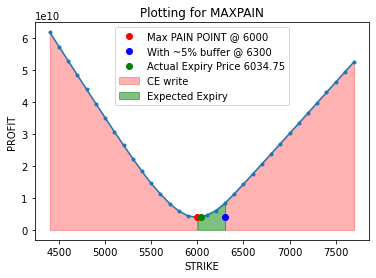

In [32]:
plot_max_pain(ex_strikes[0],ex_pain_point[0],exipy_prices['price'][0])


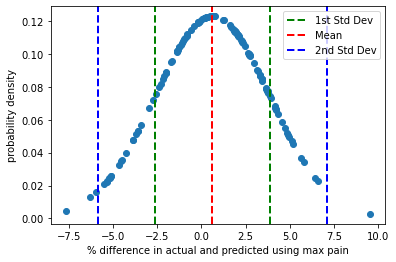

In [11]:

def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(math.pi * 2)
    return np.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / (sqrt_two_pi * sigma)

mean = mp['diff'].mean()
std = mp['diff'].std()
first_std_range = (mean - std, mean + std)
second_std_range = (mean - 2*std, mean + 2*std)

plt.scatter(mp['diff'],normal_pdf(mp['diff'],mean,std) )
plt.axvline(first_std_range[0], color='g', linestyle='--', linewidth=2, label='1st Std Dev')
plt.axvline(first_std_range[1], color='g', linestyle='--', linewidth=2)
plt.axvline(mean, color='r', linestyle='--', linewidth=2, label='Mean')
plt.axvline(second_std_range[0], color='b', linestyle='--', linewidth=2, label='2nd Std Dev')
plt.axvline(second_std_range[1], color='b', linestyle='--', linewidth=2)
plt.xlabel('% difference in actual and predicted using max pain')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [12]:
print(mean)
print(first_std_range, '~68%')
print(second_std_range, '~95%')

0.6152485323959672
(-2.6321360712228046, 3.862633136014739) ~68%
(-5.879520674841576, 7.110017739633511) ~95%


# rough

### s=nse.nsefetch('https://www.nseindia.com/api/historical/foCPV?from=01-04-2014&to=26-06-2014&instrumentType=OPTIDX&symbol=NIFTY&year=2014&strikePrice=2700.00&expiryDate=26-Jun-2014&optionType=CE&csv=true')
s=nse.nsefetch('https://www.nseindia.com/api/historical/foCPV?from=25-06-2014&to=26-06-2014&instrumentType=OPTIDX&symbol=NIFTY&expiryDate=26-Jun-2014&optionType=CE&csv=true')
s=pd.DataFrame.from_records(s["data"])